### Feature Analysis: Interpretability of ML models
March 2022

**Import Libraries**

In [32]:
import eli5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import string
import sys
import os
import warnings


from lightgbm.sklearn import LGBMClassifier
#from plotting_functions import *
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import (

    cross_val_score,
    cross_validate,
    train_test_split,
)

from sklearn.preprocessing import (
    StandardScaler,
)
from utils import *
from xgboost import XGBClassifier

%matplotlib inline
warnings.filterwarnings('ignore')


In [2]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

**Import and inspect Data**

In [3]:
path = os.getcwd()
path

'/Users/hasana/Documents/projects'

In [4]:
path = os.getcwd()
data = pd.read_excel(os.path.join(path, "Feature Analysis/data/pumpkin.xlsx"), sheet_name = "Pumpkin_Seeds_Dataset")

In [5]:
data.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Convex_Area,Equiv_Diameter,Eccentricity,Solidity,Extent,Roundness,Aspect_Ration,Compactness,Class
0,56276,888.242,326.1485,220.2388,56831,267.6805,0.7376,0.9902,0.7453,0.8963,1.4809,0.8207,Çerçevelik
1,76631,1068.146,417.1932,234.2289,77280,312.3614,0.8275,0.9916,0.7151,0.8440,1.7811,0.7487,Çerçevelik
2,71623,1082.987,435.8328,211.0457,72663,301.9822,0.8749,0.9857,0.7400,0.7674,2.0651,0.6929,Çerçevelik
3,66458,992.051,381.5638,222.5322,67118,290.8899,0.8123,0.9902,0.7396,0.8486,1.7146,0.7624,Çerçevelik
4,66107,998.146,383.8883,220.4545,67117,290.1207,0.8187,0.9850,0.6752,0.8338,1.7413,0.7557,Çerçevelik


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               2500 non-null   int64  
 1   Perimeter          2500 non-null   float64
 2   Major_Axis_Length  2500 non-null   float64
 3   Minor_Axis_Length  2500 non-null   float64
 4   Convex_Area        2500 non-null   int64  
 5   Equiv_Diameter     2500 non-null   float64
 6   Eccentricity       2500 non-null   float64
 7   Solidity           2500 non-null   float64
 8   Extent             2500 non-null   float64
 9   Roundness          2500 non-null   float64
 10  Aspect_Ration      2500 non-null   float64
 11  Compactness        2500 non-null   float64
 12  Class              2500 non-null   object 
dtypes: float64(10), int64(2), object(1)
memory usage: 254.0+ KB


In [7]:
data = data.rename(columns=str.lower)

In [8]:
data.area.value_counts()

75637    3
97268    3
68063    3
96928    2
76461    2
        ..
76581    1
70110    1
66208    1
80529    1
80011    1
Name: area, Length: 2424, dtype: int64

**Define column types for column transformation**

In [9]:
numeric_columns = data.columns[1:-1]
target_column = "class"
drop_column = ["area"]

In [10]:
numeric_transformer = make_pipeline(StandardScaler())

preprocessor = make_column_transformer(
    ("drop", drop_column),
    (numeric_transformer, numeric_columns)
)

**Split Data**

In [11]:
train, test = train_test_split(data, test_size=0.2, random_state=2022)

X_train = train.drop(columns=[target_column])
y_train = train[target_column]

X_test = test.drop(columns=[target_column])
y_test = test[target_column]

**Check for class Balance**

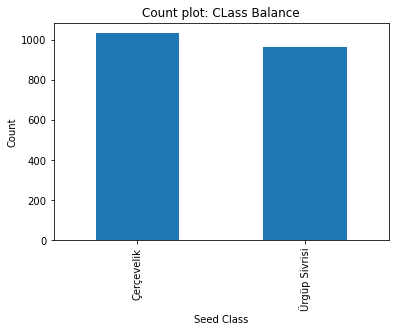

In [12]:
train["class"].value_counts().plot(kind = "bar",
                                   title = "Count plot: CLass Balance",
                                   xlabel = "Seed Class",
                                   ylabel = "Count"
                                  );

In [13]:
# not a perfect balance, but we can work with this

**Initialize Models**

In [14]:
results = {}
scoring_metric = "accuracy"

pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=2000, random_state=2022)
)
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=2022))
pipe_xgb = make_pipeline(
    preprocessor, XGBClassifier(random_state=2022)
)
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=2022))
classifiers = {
    "logistic regression": pipe_lr,
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
}

In [15]:
for (name, model) in classifiers.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )

[19:29:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:29:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:29:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:29:16] WARNING: /Users/runner/miniforge3/cond

In [16]:
pd.DataFrame(results)

,logistic regression,random forest,XGBoost,LightGBM
fit_time,0.026 (+/- 0.007),0.366 (+/- 0.017),0.306 (+/- 0.054),0.079 (+/- 0.011)
score_time,0.004 (+/- 0.000),0.018 (+/- 0.001),0.005 (+/- 0.001),0.005 (+/- 0.000)
test_score,0.880 (+/- 0.014),0.891 (+/- 0.023),0.879 (+/- 0.026),0.879 (+/- 0.022)
train_score,0.882 (+/- 0.005),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000)


**Score Interpretation**

- Random Forest is the best model
- Logistic regression gives a better score than the gradient boosting models.
- XGBoost and LightGBM are gives good scores without hyper parameters.

#### Logistic Regression : Feature Importance In Linear Model

In [17]:
pipe_lr.fit(X_train, y_train)

lr_data = {
    "coefficient": pipe_lr.named_steps["logisticregression"].coef_.flatten().tolist(),
    "magnitude": np.absolute(
        pipe_lr.named_steps["logisticregression"].coef_.flatten().tolist()
    ),
}
coef_lr = pd.DataFrame(lr_data, index= numeric_columns).sort_values(
    "coefficient", ascending=False
)

In [18]:
coef_lr

,coefficient,magnitude
convex_area,2.591466,2.591466
aspect_ration,1.785008,1.785008
solidity,0.703159,0.703159
major_axis_length,0.346242,0.346242
extent,0.018317,0.018317
minor_axis_length,-0.230135,0.230135
roundness,-1.034266,1.034266
perimeter,-1.161847,1.161847
equiv_diameter,-1.547765,1.547765
eccentricity,-1.597774,1.597774


In [19]:
pipe_lr.classes_ 

array(['Çerçevelik', 'Ürgüp Sivrisi'], dtype=object)

### Interpretation of Coefficients of Logistics Model
NOTE : The default class set by the logistic regression model is : 
- `Çerçevelik` is the class with index 0 or the positive class (based on the magnitude of the coefficient) and
- `Ürgüp Sivrisi` the class with index 1 or negative class  (based on the magnitude of the coefficient)



### Increasing Compactness 

In [20]:
example_1a = X_test[255:256].copy()
example_1a['compactness'] = example_1a['compactness'] * 2

print(f' The prediction when compactness is increased is: {pipe_lr.predict(example_1a)[0]}')
example_1a

 The prediction when compactness is increased is: Çerçevelik


,area,perimeter,major_axis_length,minor_axis_length,convex_area,equiv_diameter,eccentricity,solidity,extent,roundness,aspect_ration,compactness
1882,96325,1305.855,551.395,224.9857,97155,350.2068,0.913,0.9915,0.5223,0.7098,2.4508,1.2702


### Decreasing Compactness 

In [21]:
example_1b = X_test[255:256].copy()
example_1b['compactness'] = example_1b['compactness'] / 2


print(f' The prediction when compactness is decreased is: {pipe_lr.predict(example_1b)[0]}')
example_1b

 The prediction when compactness is decreased is: Ürgüp Sivrisi


,area,perimeter,major_axis_length,minor_axis_length,convex_area,equiv_diameter,eccentricity,solidity,extent,roundness,aspect_ration,compactness
1882,96325,1305.855,551.395,224.9857,97155,350.2068,0.913,0.9915,0.5223,0.7098,2.4508,0.31755


### Increasing Convex Area

In [22]:
example_2a = X_test[255:256].copy()
example_2a['convex_area'] = example_2a['convex_area'] * 2

print(f'The prediction when convex area is increased is: {pipe_lr.predict(example_2a)[0]}')
example_2a

The prediction when convex area is increased is: Ürgüp Sivrisi


,area,perimeter,major_axis_length,minor_axis_length,convex_area,equiv_diameter,eccentricity,solidity,extent,roundness,aspect_ration,compactness
1882,96325,1305.855,551.395,224.9857,194310,350.2068,0.913,0.9915,0.5223,0.7098,2.4508,0.6351


### Decreasing Convex Area

In [23]:
example_2b = X_test[255:256].copy()
example_2b['convex_area'] = example_2b['convex_area'] / 2

print(f' The prediction when convex area is decreased is: {pipe_lr.predict(example_2b)[0]}')
example_2b

 The prediction when convex area is decreased is: Çerçevelik


,area,perimeter,major_axis_length,minor_axis_length,convex_area,equiv_diameter,eccentricity,solidity,extent,roundness,aspect_ration,compactness
1882,96325,1305.855,551.395,224.9857,48577.5,350.2068,0.913,0.9915,0.5223,0.7098,2.4508,0.6351


The coefficients of the model is interpreted thus: 

- Increasing the `compactness` is likely to push the prediction towards `Çerçevelik`
- Increasing the `convex area` is likely to push the prediction towards `Ürgüp Sivrisi`
- Decreasing the `compactness` is likely to push the prediction towards `Ürgüp Sivrisi`
- Decreasing the `convex area` is likely to push the prediction towards `Çerçevelik`

### Random Forest: Feature Importance in Decision Tree Model

In [24]:
pipe_rf.fit(X_train, y_train)
data = {
    "Importance": pipe_rf.named_steps["randomforestclassifier"].feature_importances_,
}
pd.DataFrame(data=data, index= numeric_columns).sort_values(
    by="Importance", ascending=False
)[:10]


,Importance
aspect_ration,0.204342
eccentricity,0.200888
compactness,0.175086
roundness,0.106204
major_axis_length,0.070736
solidity,0.053879
minor_axis_length,0.042710
extent,0.042271
perimeter,0.036539
equiv_diameter,0.033754


In [25]:
# feature importance

eli5.explain_weights( pipe_rf.named_steps["randomforestclassifier"], feature_names=numeric_columns.to_list())


Weight,Feature
0.2043 ± 0.4834,aspect_ration
0.2009 ± 0.4856,eccentricity
0.1751 ± 0.4416,compactness
0.1062 ± 0.3060,roundness
0.0707 ± 0.1798,major_axis_length
0.0539 ± 0.0288,solidity
0.0427 ± 0.0697,minor_axis_length
0.0423 ± 0.0398,extent
0.0365 ± 0.0478,perimeter
0.0338 ± 0.0230,equiv_diameter


 - The most important feature in prediction is the aspect ratio. To see how it affect the predictions, we will use the same test example

### Decreasing Aspect Ratio

In [26]:

example_rnd_dcr = X_test[255:256].copy()
example_rnd_dcr[''] = example_rnd_dcr['aspect_ration'] / 2

print(f'The prediction when aspect_ration is decreased is: {pipe_lr.predict(example_rnd_dcr)[0]}')

example_rnd_dcr


The prediction when aspect_ration is decreased is: Ürgüp Sivrisi


,area,perimeter,major_axis_length,minor_axis_length,convex_area,equiv_diameter,eccentricity,solidity,extent,roundness,aspect_ration,compactness,
1882,96325,1305.855,551.395,224.9857,97155,350.2068,0.913,0.9915,0.5223,0.7098,2.4508,0.6351,1.2254


In [27]:


example_rnd_incr = X_test[255:256].copy()
example_rnd_incr['aspect_ration'] = example_rnd_incr['aspect_ration'] * 2

print(f'The prediction when aspect_ration is increased is: {pipe_lr.predict(example_rnd_incr)[0]}')
example_rnd_incr


The prediction when aspect_ration is increased is: Ürgüp Sivrisi


,area,perimeter,major_axis_length,minor_axis_length,convex_area,equiv_diameter,eccentricity,solidity,extent,roundness,aspect_ration,compactness
1882,96325,1305.855,551.395,224.9857,97155,350.2068,0.913,0.9915,0.5223,0.7098,4.9016,0.6351



From the prediciton examples above, we can see that increasing or decreasing `aspect_ratio` did not influence the prediction class

### Light GBM: Feature Importance in Gradient Boosting Model

In [30]:
pipe_lgbm.fit(X_train, y_train);

### Explaining predictions with shap

In [31]:
#create train dataframes with transformed features.
X_train_enc.head()
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=numeric_columns,
    index=X_train.index,
)
X_train_enc.shape


(2000, 11)

In [33]:
#create test dataframes with transformed features.
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=numeric_columns,
    index=X_test.index,
)
X_test_enc.shape

(500, 11)

In [34]:
#  SHAP values for train data.
lgbm_explainer = shap.TreeExplainer(pipe_lgbm.named_steps["lgbmclassifier"])
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)

train_lgbm_shap_values[1].shape


(2000, 11)

In [36]:
# SHAP values for test data.
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc)
test_lgbm_shap_values[1].shape

(500, 11)

In [37]:
y_test_reset = y_test.reset_index(drop=True)
y_test_reset

0         Çerçevelik
1      Ürgüp Sivrisi
2         Çerçevelik
3         Çerçevelik
4      Ürgüp Sivrisi
           ...      
495    Ürgüp Sivrisi
496    Ürgüp Sivrisi
497    Ürgüp Sivrisi
498    Ürgüp Sivrisi
499       Çerçevelik
Name: class, Length: 500, dtype: object

In [39]:
# get samples for the two classes
c_ind = y_test_reset[y_test_reset == "Çerçevelik"].index.tolist()
u_ind = y_test_reset[y_test_reset == "Ürgüp Sivrisi"].index.tolist()

c_index = c_ind[10]
u_index = u_ind[10]

### Examples with `Çerçevelik`

In [47]:
pipe_lgbm.named_steps["lgbmclassifier"].classes_

array(['Çerçevelik', 'Ürgüp Sivrisi'], dtype=object)

In [43]:
# predicted probability for class `Çerçevelik`
pipe_lgbm.named_steps["lgbmclassifier"].predict_proba(X_test_enc)[c_index]

array([0.96647412, 0.03352588])

In [46]:
# raw score of the model for class `Çerçevelik`
pipe_lgbm.named_steps["lgbmclassifier"].predict(X_test_enc, raw_score=True)[
    c_index
]  

-3.361336750718783

In [45]:
# mean prediction for class  Çerçevelik
pipe_lgbm.named_steps["lgbmclassifier"].predict(X_train_enc, raw_score=True).mean()

0.49345559710892356

In [51]:
# on average this is the raw score for class `Ürgüp Sivrisi`
lgbm_explainer.expected_value[1]  

0.4934555971089238

In [52]:
# on average this is the raw score for class `Çerçevelik`
lgbm_explainer.expected_value[0]

-0.4934555971089238

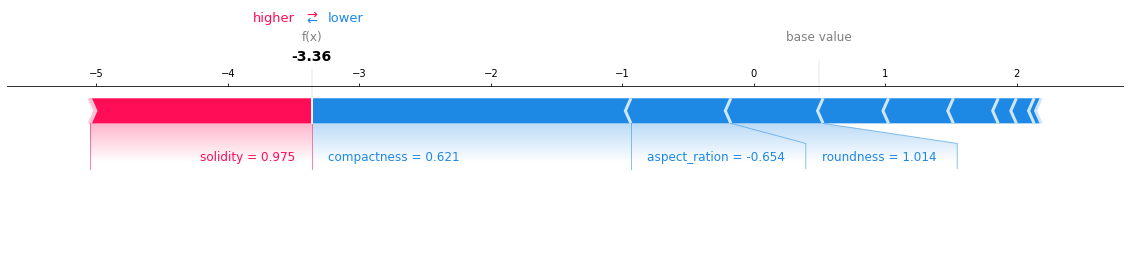

In [56]:
# visualization

X_test_enc = round(X_test_enc, 3)  
shap.force_plot(
    lgbm_explainer.expected_value[1],
    test_lgbm_shap_values[1][c_index, :],
    X_test_enc.iloc[c_index, :],
    matplotlib=True,
)


#### Interpretation
- Solidity is pushing the prediction towards an higher raw score
- While compactness, aspect_ration and roundness are pushing the prediction towards a lower raw score

In addition, the base value is higher than the raw score

In [58]:
#
shape_value_cindex = pd.DataFrame(
    test_lgbm_shap_values[1][c_index, :],
    index=numeric_columns,
    columns=["SHAP values"],
)
shape_value_cindex

,SHAP values
perimeter,-0.138066
major_axis_length,-0.497464
minor_axis_length,0.008112
convex_area,-0.134924
equiv_diameter,-0.493279
eccentricity,-0.053543
solidity,1.684569
extent,-0.341245
roundness,-0.701621
aspect_ration,-0.760125
